In [117]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from sklearn.model_selection import train_test_split
import torch.nn as nn
from tqdm import tqdm
from sklearn import preprocessing
import pandas as pd 
from sklearn.metrics import precision_score, confusion_matrix

In [2]:
def days_list(dataframe):
    df = dataframe.copy()
    df['Datetime'] = pd.to_datetime(df['Datetime'])

    # Extract the date from the datetime column
    df['Date'] = df['Datetime'].dt.date

    # Calculate the number of minutes for each date
    minutes_per_day = df.groupby('Date')['Datetime'].count()

    # Find dates with a complete set of minutes (e.g., 390 minutes for a full trading day)
    complete_days = minutes_per_day[minutes_per_day == 390].index

    # Filter the DataFrame to include only rows for complete days
    df = df[df['Date'].isin(complete_days)].drop(columns=['Date'])
    
    df.set_index('Datetime', inplace=True)
    
    # Group the data by day
    daily_groups = df.groupby(pd.Grouper(freq='D'))
    
    # Create a list of DataFrames, each representing a day without empty days
    daily_dataframes = [group[1].reset_index(drop=False) for group in daily_groups if not group[1].empty]
    
    return daily_dataframes


In [62]:
data = pd.read_csv(r"META_2022-03-15_2024-03-15") 
comp_days = days_list(data)

In [78]:
n = 20
t = 5
time = 10
threshold = 0.001
X,Y = [], [] 
for day in tqdm(comp_days[:400]):
    prices = day["Close"].tolist()
    volumes = day["Volume"].tolist()
    for i in range(0, len(prices)-n+1, t):
        par_p = prices[i:i + n]
        par_v = volumes[i:i + n]
        x = [[par_p[j] / par_p[j - 1], par_v[j]/par_v[j-1]] for j in range(1, len(par_p))]
        

        ind = i+n
        outliers = [ ]
        l_cluster =[]
        coef_l = []
        
        while not any(outliers) and ind <=388:
            l_cluster += [prices[ind]]
            ind+=1
            value = prices[ind]
            
            y = l_cluster + [value]
                
            x_t = np.array(range(0,len(y)))

            coef_l = np.polyfit(x_t, y, 1)
            poly1d_fn = np.poly1d(coef_l) 

            res = y - poly1d_fn(x_t)
            difference = threshold * y[-1] 
            outliers = [r > difference for r in res]
        
        if list(coef_l):
            if coef_l[0]>=0:
                y  = 1
            else:
                y  = 0
            X.append(x)
            Y.append(y) 
X = np.array(X)
Y = np.array(Y)

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:58<00:00,  6.86it/s]


In [81]:
def normalize_list(X):
    # Concatenate all matrices in X along the first axis
    combined_x = np.concatenate(X, axis=0)
    
    # Calculate mean and std for each column across all matrices
    mean_col0 = np.mean(combined_x[:, 0])
    std_col0 = np.std(combined_x[:, 0])
    mean_col1 = np.mean(combined_x[:, 1])
    std_col1 = np.std(combined_x[:, 1])
    
    normalized_X = []
    for x in X:
        # Normalize each column using the overall mean and std
        normalized_col0 = (x[:, 0] - mean_col0) / std_col0
        normalized_col1 = (x[:, 1] - mean_col1) / std_col1
        
        # Concatenate normalized columns into a matrix
        normalized_x = np.column_stack((normalized_col0, normalized_col1))
        normalized_X.append(normalized_x)
        
    return normalized_X, (mean_col0,std_col0, mean_col1, std_col1)

X, norm_const = normalize_list(X)

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, shuffle=False, random_state=42)

In [89]:
X_train = torch.tensor(X_train)
y_train = torch.tensor(y_train)

X_test = torch.tensor(X_test)
y_test = torch.tensor(y_test)

In [90]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, 16)
        self.act0 = nn.ReLU()
        self.layer1 = nn.Linear(16, 4)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(4, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, data, hidden):
        
        combined = torch.cat((data.float(), hidden.float()), 0).float()
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.act0(output)
        output = self.act1(self.layer1(output))
        output = self.layer2(output)
        output = self.sigmoid(output)  # Use sigmoid activation
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
    
model = RNN(2,8)
model.apply(init_weights)

RNN(
  (i2h): Linear(in_features=10, out_features=8, bias=True)
  (i2o): Linear(in_features=10, out_features=16, bias=True)
  (act0): ReLU()
  (layer1): Linear(in_features=16, out_features=4, bias=True)
  (act1): ReLU()
  (layer2): Linear(in_features=4, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [91]:
class_counts = [0, 0]  # Initialize counts for each class

# Count the number of samples in each class
for y in y_train:
    class_counts[y] += 1

class_counts

[13279, 13361]

In [92]:
# Create a DataLoader with the oversampling sampler
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=500)

val_dataset = TensorDataset(X_test, y_test)
val_loader = DataLoader(val_dataset, batch_size=500)

criterion = torch.nn.BCELoss()  # Binary Cross Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [93]:
n_epochs = 10

losses = []
val_losses = []
for epoch in tqdm(range(n_epochs)):
    epoch_loss = 0
    val_loss = 0
    model.train()
    for inputs, labels in  tqdm(train_loader):
        
        hidden = model.initHidden()
        optimizer.zero_grad()
        
        outputs = []
        for X in inputs:  
            for t in range(X.size()[0]):
                output, hidden = model(X[t], hidden)
                
            outputs.append(output)
            
        outputs_tensor = torch.cat(outputs, dim=0)
        labels = labels.float()
        
        
        loss = criterion(outputs_tensor, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        
    model.eval()     # Optional when not using Model Specific layer
    for inputs, labels in val_loader:
        hidden = model.initHidden()
        
        outputs = []
        for X in inputs:  
            for t in range(X.size()[0]):
                output, hidden = model(X[t], hidden)
            outputs.append(output)
        outputs_tensor = torch.cat(outputs, dim=0)
        labels = labels.float()
        loss = criterion(outputs_tensor, labels)
        val_loss += loss.item()
        
    print(outputs_tensor)
    average_epoch_loss = epoch_loss / len(train_loader.dataset)
    losses.append(average_epoch_loss)
    average_vall_loss = epoch_loss / len(val_loader.dataset)
    val_losses.append(average_vall_loss)
       

  0%|                                                                                           | 0/54 [00:00<?, ?it/s]

tensor([0.5501, 0.4933, 0.4934, 0.4933, 0.5502, 0.4901, 0.4992, 0.4850, 0.5072,
        0.4857, 0.4877, 0.5151, 0.4892, 0.8781, 0.6446, 0.4948, 0.5111, 0.5202,
        0.6561, 0.5207, 0.6293, 0.6410, 0.4749, 0.4883, 0.5066, 0.4934, 0.4905,
        0.5267, 0.4922, 0.4934, 0.5289, 0.5679, 0.4934, 0.5376, 0.4829, 0.4773,
        0.4917, 0.4944, 0.6541, 0.5339, 0.5470, 0.4934, 0.4922, 0.4977, 0.5140,
        0.5003, 0.5118, 0.5102, 0.4934, 0.4834, 0.4934, 0.5093, 0.5707, 0.4802,
        0.4906, 0.5158, 0.4934, 0.4905, 0.5465, 0.5270, 0.4934, 0.5215, 0.4856,
        0.4934, 0.4841, 0.5121, 0.5141, 0.6062, 0.5739, 0.5437, 0.5050, 0.4934,
        0.4912, 0.5321, 0.5941, 0.4841, 0.4900, 0.4950, 0.5388, 0.5035, 0.4815,
        0.4934, 0.4787, 0.5035, 0.4929, 0.4904, 0.5425, 0.4934, 0.4836, 0.5516,
        0.5983, 0.6791, 0.5168, 0.4779, 0.4934, 0.4776, 0.5390, 0.4890, 0.5213,
        0.4934, 0.4874, 0.4901, 0.4933, 0.4276, 0.4575, 0.4899, 0.4934, 0.4921,
        0.4934, 0.5307, 0.4840, 0.4941, 


  0%|                                                                                           | 0/54 [00:00<?, ?it/s]

tensor([0.5095, 0.4902, 0.4916, 0.4916, 0.5229, 0.4876, 0.4949, 0.4845, 0.5031,
        0.4837, 0.4854, 0.4899, 0.4879, 0.6848, 0.5660, 0.4896, 0.4889, 0.5012,
        0.5991, 0.4916, 0.5592, 0.5723, 0.4755, 0.4872, 0.4904, 0.4902, 0.4848,
        0.4994, 0.4910, 0.4916, 0.5043, 0.5155, 0.4916, 0.5267, 0.4813, 0.4786,
        0.4903, 0.4913, 0.6012, 0.5194, 0.5046, 0.4916, 0.4854, 0.4891, 0.4916,
        0.4916, 0.4994, 0.4909, 0.4916, 0.4820, 0.4909, 0.4916, 0.5236, 0.4779,
        0.4876, 0.5148, 0.4916, 0.4911, 0.5188, 0.4922, 0.4916, 0.5165, 0.4844,
        0.4916, 0.4840, 0.4916, 0.4882, 0.5692, 0.5315, 0.5081, 0.4916, 0.4916,
        0.4903, 0.4980, 0.5559, 0.4909, 0.4872, 0.4870, 0.4946, 0.4916, 0.4808,
        0.4916, 0.4788, 0.4916, 0.4910, 0.4881, 0.5044, 0.4916, 0.4843, 0.5180,
        0.5407, 0.6492, 0.4916, 0.4796, 0.4916, 0.4772, 0.4950, 0.4849, 0.4950,
        0.4916, 0.4857, 0.4893, 0.4916, 0.4500, 0.4668, 0.4885, 0.4916, 0.4916,
        0.4916, 0.5242, 0.4849, 0.4884, 


  0%|                                                                                           | 0/54 [00:00<?, ?it/s]

tensor([0.4918, 0.4915, 0.4923, 0.4923, 0.5098, 0.4892, 0.4952, 0.4868, 0.5005,
        0.4857, 0.4872, 0.4919, 0.4902, 0.5139, 0.5270, 0.4913, 0.4853, 0.4983,
        0.5629, 0.4923, 0.5353, 0.5529, 0.4800, 0.4892, 0.4906, 0.4908, 0.4873,
        0.4919, 0.4920, 0.4923, 0.4923, 0.4916, 0.4923, 0.5240, 0.4838, 0.4822,
        0.4923, 0.4923, 0.5692, 0.5062, 0.4925, 0.4923, 0.4868, 0.4861, 0.4923,
        0.4923, 0.5007, 0.4923, 0.4923, 0.4847, 0.4923, 0.4923, 0.5087, 0.4813,
        0.4887, 0.5077, 0.4923, 0.4920, 0.5080, 0.4892, 0.4923, 0.5269, 0.4871,
        0.4923, 0.4868, 0.4923, 0.4900, 0.5508, 0.5106, 0.4976, 0.4923, 0.4923,
        0.4920, 0.4923, 0.5363, 0.4954, 0.4886, 0.4897, 0.4920, 0.4923, 0.4840,
        0.4923, 0.4832, 0.4923, 0.4921, 0.4897, 0.4959, 0.4923, 0.4887, 0.4980,
        0.5100, 0.6192, 0.4923, 0.4850, 0.4923, 0.4811, 0.4923, 0.4867, 0.4910,
        0.4923, 0.4870, 0.4914, 0.4923, 0.4873, 0.4751, 0.4903, 0.4923, 0.4923,
        0.4923, 0.5215, 0.4891, 0.4898, 


  0%|                                                                                           | 0/54 [00:00<?, ?it/s]

tensor([0.4935, 0.4933, 0.4936, 0.4936, 0.5031, 0.4913, 0.4989, 0.4894, 0.5018,
        0.4882, 0.4895, 0.4936, 0.4925, 0.4936, 0.5073, 0.4931, 0.4877, 0.4973,
        0.5431, 0.4936, 0.5249, 0.5441, 0.4843, 0.4913, 0.4921, 0.4925, 0.4898,
        0.4936, 0.4932, 0.4936, 0.4936, 0.4865, 0.4936, 0.5241, 0.4867, 0.4861,
        0.4936, 0.4936, 0.5481, 0.5018, 0.4888, 0.4936, 0.4893, 0.4885, 0.4932,
        0.4936, 0.5026, 0.4936, 0.4936, 0.4875, 0.4936, 0.4936, 0.5038, 0.4844,
        0.4904, 0.5061, 0.4936, 0.4934, 0.5012, 0.4905, 0.4936, 0.5305, 0.4896,
        0.4936, 0.4894, 0.4936, 0.4915, 0.5399, 0.4995, 0.4940, 0.4936, 0.4936,
        0.4936, 0.4936, 0.5261, 0.4985, 0.4905, 0.4919, 0.4936, 0.4936, 0.4870,
        0.4936, 0.4868, 0.4936, 0.4936, 0.4916, 0.4928, 0.4936, 0.4918, 0.4896,
        0.4947, 0.6012, 0.4936, 0.4891, 0.4936, 0.4848, 0.4936, 0.4890, 0.4920,
        0.4936, 0.4889, 0.4934, 0.4936, 0.5024, 0.4811, 0.4924, 0.4936, 0.4936,
        0.4936, 0.5204, 0.4922, 0.4919, 


  0%|                                                                                           | 0/54 [00:00<?, ?it/s]

tensor([0.4949, 0.4949, 0.4949, 0.4949, 0.4986, 0.4930, 0.5036, 0.4916, 0.5062,
        0.4904, 0.4915, 0.4949, 0.4944, 0.4949, 0.4999, 0.4946, 0.4896, 0.4978,
        0.5295, 0.4949, 0.5195, 0.5395, 0.4874, 0.4930, 0.4936, 0.4941, 0.4919,
        0.4949, 0.4942, 0.4949, 0.4944, 0.4890, 0.4949, 0.5264, 0.4891, 0.4903,
        0.4949, 0.4955, 0.5355, 0.5033, 0.4914, 0.4949, 0.4915, 0.4924, 0.4938,
        0.4949, 0.5061, 0.4947, 0.4949, 0.4899, 0.4949, 0.4949, 0.5022, 0.4869,
        0.4918, 0.5085, 0.4949, 0.4946, 0.4961, 0.4913, 0.4949, 0.5316, 0.4914,
        0.4949, 0.4915, 0.4949, 0.4918, 0.5331, 0.4933, 0.4928, 0.4949, 0.4949,
        0.4949, 0.4949, 0.5202, 0.5019, 0.4919, 0.4936, 0.4949, 0.4949, 0.4893,
        0.4949, 0.4894, 0.4949, 0.4949, 0.4933, 0.4918, 0.4949, 0.4941, 0.4897,
        0.4949, 0.5943, 0.4949, 0.4923, 0.4949, 0.4879, 0.4949, 0.4909, 0.4929,
        0.4949, 0.4909, 0.4949, 0.4949, 0.4997, 0.4849, 0.4941, 0.4949, 0.4949,
        0.4949, 0.5232, 0.4944, 0.4937, 


  0%|                                                                                           | 0/54 [00:00<?, ?it/s]

tensor([0.4960, 0.4960, 0.4960, 0.4960, 0.4966, 0.4940, 0.5058, 0.4933, 0.5082,
        0.4923, 0.4931, 0.4960, 0.4957, 0.4960, 0.4960, 0.4958, 0.4912, 0.5013,
        0.5236, 0.4960, 0.5203, 0.5386, 0.4897, 0.4943, 0.4947, 0.4954, 0.4935,
        0.4960, 0.4948, 0.4960, 0.4942, 0.4909, 0.4960, 0.5256, 0.4910, 0.4928,
        0.4960, 0.4973, 0.5318, 0.4997, 0.4934, 0.4960, 0.4932, 0.4947, 0.4937,
        0.4960, 0.5067, 0.4947, 0.4960, 0.4917, 0.4960, 0.4960, 0.5040, 0.4885,
        0.4930, 0.5075, 0.4960, 0.4952, 0.4944, 0.4913, 0.4960, 0.5288, 0.4928,
        0.4960, 0.4930, 0.4957, 0.4912, 0.5298, 0.4925, 0.4939, 0.4960, 0.4960,
        0.4960, 0.4957, 0.5184, 0.5027, 0.4930, 0.4946, 0.4960, 0.4960, 0.4910,
        0.4960, 0.4914, 0.4960, 0.4957, 0.4947, 0.4935, 0.4960, 0.4957, 0.4889,
        0.4960, 0.5820, 0.4960, 0.4948, 0.4960, 0.4903, 0.4960, 0.4923, 0.4935,
        0.4960, 0.4927, 0.4960, 0.4960, 0.4946, 0.4874, 0.4955, 0.4960, 0.4960,
        0.4960, 0.5231, 0.4960, 0.4953, 


  0%|                                                                                           | 0/54 [00:00<?, ?it/s]

tensor([0.4969, 0.4969, 0.4969, 0.4966, 0.4941, 0.4942, 0.5089, 0.4946, 0.5101,
        0.4937, 0.4943, 0.4969, 0.4967, 0.4969, 0.4969, 0.4967, 0.4923, 0.5054,
        0.5176, 0.4969, 0.5217, 0.5384, 0.4915, 0.4951, 0.4952, 0.4965, 0.4947,
        0.4967, 0.4948, 0.4969, 0.4933, 0.4924, 0.4969, 0.5250, 0.4924, 0.4957,
        0.4969, 0.4983, 0.5274, 0.4980, 0.4949, 0.4969, 0.4945, 0.4974, 0.4931,
        0.4969, 0.5083, 0.4942, 0.4969, 0.4931, 0.4969, 0.4969, 0.5064, 0.4890,
        0.4937, 0.5046, 0.4969, 0.4955, 0.4922, 0.4906, 0.4969, 0.5252, 0.4935,
        0.4969, 0.4941, 0.4951, 0.4898, 0.5259, 0.4916, 0.4961, 0.4963, 0.4969,
        0.4969, 0.4950, 0.5162, 0.5041, 0.4934, 0.4947, 0.4969, 0.4969, 0.4919,
        0.4969, 0.4927, 0.4969, 0.4961, 0.4956, 0.4962, 0.4969, 0.4969, 0.4874,
        0.4960, 0.5711, 0.4969, 0.4966, 0.4969, 0.4922, 0.4969, 0.4927, 0.4936,
        0.4969, 0.4936, 0.4969, 0.4969, 0.4936, 0.4920, 0.4965, 0.4969, 0.4969,
        0.4969, 0.5229, 0.4969, 0.4965, 


  0%|                                                                                           | 0/54 [00:00<?, ?it/s]

tensor([0.4976, 0.4976, 0.4972, 0.4963, 0.4922, 0.4941, 0.5094, 0.4956, 0.5098,
        0.4945, 0.4953, 0.4976, 0.4975, 0.4976, 0.4976, 0.4974, 0.4931, 0.5087,
        0.5124, 0.4976, 0.5233, 0.5385, 0.4927, 0.4957, 0.4954, 0.4973, 0.4955,
        0.4967, 0.4947, 0.4976, 0.4920, 0.4935, 0.4976, 0.5241, 0.4935, 0.4970,
        0.4976, 0.4989, 0.5224, 0.4937, 0.4960, 0.4976, 0.4955, 0.4979, 0.4921,
        0.4969, 0.5086, 0.4933, 0.4974, 0.4941, 0.4976, 0.4976, 0.5086, 0.4893,
        0.4940, 0.5015, 0.4976, 0.4957, 0.4916, 0.4899, 0.4976, 0.5222, 0.4939,
        0.4976, 0.4950, 0.4940, 0.4887, 0.5225, 0.4905, 0.4975, 0.4957, 0.4976,
        0.4968, 0.4943, 0.5137, 0.5044, 0.4935, 0.4947, 0.4976, 0.4976, 0.4926,
        0.4976, 0.4939, 0.4976, 0.4962, 0.4959, 0.4982, 0.4976, 0.4976, 0.4855,
        0.4950, 0.5617, 0.4976, 0.4976, 0.4975, 0.4935, 0.4968, 0.4926, 0.4934,
        0.4976, 0.4938, 0.4976, 0.4976, 0.4928, 0.4955, 0.4973, 0.4976, 0.4976,
        0.4971, 0.5221, 0.4976, 0.4974, 


  0%|                                                                                           | 0/54 [00:00<?, ?it/s]

tensor([0.4983, 0.4983, 0.4973, 0.4959, 0.4901, 0.4940, 0.5104, 0.4962, 0.5099,
        0.4950, 0.4960, 0.4983, 0.4981, 0.4983, 0.4983, 0.4982, 0.4939, 0.5100,
        0.5063, 0.4983, 0.5235, 0.5370, 0.4939, 0.4963, 0.4956, 0.4981, 0.4963,
        0.4970, 0.4945, 0.4983, 0.4907, 0.4944, 0.4983, 0.5227, 0.4943, 0.4979,
        0.4983, 0.4997, 0.5167, 0.4914, 0.4971, 0.4983, 0.4963, 0.4985, 0.4911,
        0.4960, 0.5082, 0.4924, 0.4975, 0.4950, 0.4983, 0.4983, 0.5097, 0.4893,
        0.4944, 0.4983, 0.4983, 0.4960, 0.4915, 0.4890, 0.4983, 0.5183, 0.4943,
        0.4983, 0.4954, 0.4931, 0.4873, 0.5189, 0.4895, 0.4984, 0.4953, 0.4983,
        0.4967, 0.4935, 0.5110, 0.5044, 0.4936, 0.4947, 0.4983, 0.4983, 0.4931,
        0.4983, 0.4949, 0.4983, 0.4963, 0.4962, 0.4994, 0.4983, 0.4983, 0.4834,
        0.4946, 0.5506, 0.4983, 0.4983, 0.4975, 0.4947, 0.4962, 0.4923, 0.4932,
        0.4983, 0.4938, 0.4979, 0.4983, 0.4895, 0.4985, 0.4975, 0.4983, 0.4983,
        0.4967, 0.5208, 0.4983, 0.4981, 


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [32:02<00:00, 192.30s/it]

tensor([0.4990, 0.4990, 0.4972, 0.4956, 0.4896, 0.4937, 0.5114, 0.4966, 0.5090,
        0.4953, 0.4964, 0.4990, 0.4988, 0.4990, 0.4990, 0.4986, 0.4945, 0.5115,
        0.5012, 0.4990, 0.5237, 0.5358, 0.4951, 0.4965, 0.4958, 0.4988, 0.4971,
        0.4978, 0.4943, 0.4990, 0.4897, 0.4953, 0.4990, 0.5203, 0.4946, 0.4987,
        0.4990, 0.5006, 0.5114, 0.4905, 0.4981, 0.4990, 0.4972, 0.4991, 0.4904,
        0.4950, 0.5086, 0.4915, 0.4977, 0.4959, 0.4990, 0.4990, 0.5106, 0.4892,
        0.4945, 0.4990, 0.4990, 0.4962, 0.4915, 0.4882, 0.4990, 0.5163, 0.4943,
        0.4990, 0.4952, 0.4924, 0.4858, 0.5159, 0.4887, 0.4991, 0.4951, 0.4990,
        0.4968, 0.4926, 0.5086, 0.5039, 0.4934, 0.4945, 0.4990, 0.4990, 0.4932,
        0.4990, 0.4956, 0.4990, 0.4964, 0.4963, 0.5003, 0.4990, 0.4990, 0.4815,
        0.4951, 0.5372, 0.4990, 0.4990, 0.4973, 0.4958, 0.4959, 0.4918, 0.4931,
        0.4990, 0.4938, 0.4977, 0.4990, 0.4904, 0.5018, 0.4975, 0.4990, 0.4990,
        0.4973, 0.5188, 0.4990, 0.4989, 

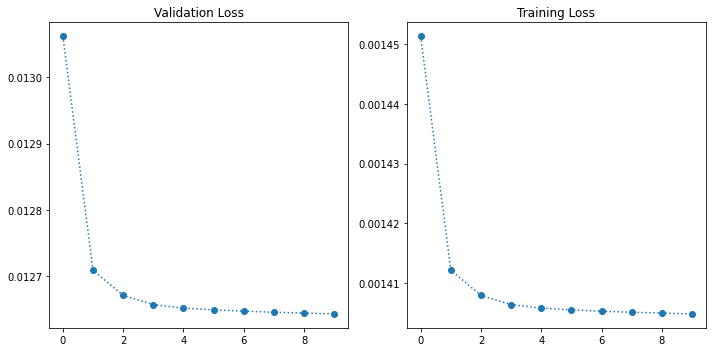

In [100]:
import plotly.express as px

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(val_losses,marker='o', linestyle=':')
axs[0].set_title('Validation Loss')

axs[1].plot(losses,marker='o', linestyle=':')
axs[1].set_title('Training Loss')


plt.tight_layout()
plt.show()

In [101]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Set model to evaluation mode
model.eval()

outputs = []
with torch.no_grad():
    for X in X_test:
        hidden = model.initHidden()
        for t in range(X.size()[0]):
            output, hidden = model(X[t], hidden)
        outputs.append(output)

In [113]:
precision_score(y_test, [1 if float(i)>0.50 else 0 for i in outputs])

0.5454545454545454

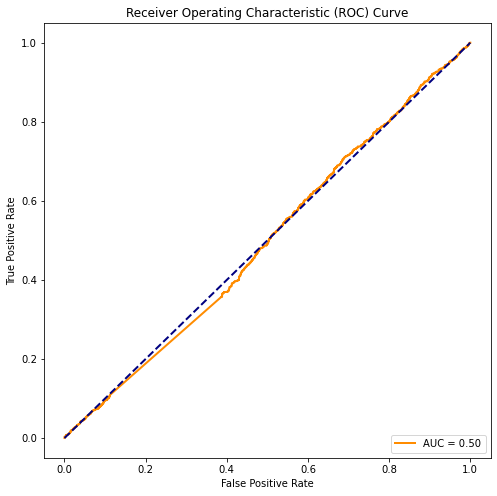

In [110]:
# Calculate the ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, [float(i) for i in outputs])
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [139]:
result = [ ]
sell_list = []
buy_list = []
initial = comp_days[400].iloc[0]["Close"]
real = []
m_p, sd_p, m_v, sd_v = norm_const

time = 10
size = 20
model.eval()

for day in tqdm(comp_days[400:]):
    b = False
    sold_ind  = 0 
    date = day["Datetime"].dt.date[0]
    day_price = []
    day_vol = []
    for ind in range(len(day))[:-1]:
        day_price.append(day["Close"][ind])
        day_vol.append(day["Volume"][ind])
        value = day["Close"][ind]
        if len(day_price) >= size:
            
            par_p = day_price[-size:]
            par_v = day_vol[-size:]
            x_p = [ par_p[j] / par_p[j - 1]  for j in range(1, len(par_p))]
            x_v = [ par_v[j] / par_v[j - 1] for j in range(1, len(par_v))]
            
            norm_p = (x_p - m_p) / sd_p
            norm_v = (x_v - m_v) / sd_v
            
            norm_x =  torch.tensor(np.column_stack((norm_p, norm_v)))
            
            
        
            with torch.no_grad():
                hidden = model.initHidden()
                for t in range(len(norm_x)):
                    output, hidden = model(norm_x[t], hidden)
                    
            if not b:             
                if output >= 0.5:
                    buy_list.append(ind+1)
                    bought = day["Open"][ind+1]
                    sold_ind = min(ind+time, 389)
                    b = True
                    current_cluster = [value]
                    
            else: 
                current_cluster.append(value)
                y = current_cluster
                x = np.array(range(0,len(y)))

                coef = np.polyfit(x, y, 1)
                poly1d_fn = np.poly1d(coef) 
                res = y - poly1d_fn(x)
                difference = threshold * y[-1]
                outliers = [r > difference for r in res]
               
                if any(outliers) or ind == 388:
                    sell_list.append(ind)
                    sold = day["Close"][ind]
                    b = False
                    result.append((sold - bought, date))
                    real.append(bought-initial)
                    if ind == 388:
                        count+=1

                    
dates = [t[1] for t in result]
values = [t[0] for t in result]

# Calculate cumulative sum
cumulative_sum = [sum(values[:i+1]) for i in range(len(values))]

#Plotting
plt.figure(figsize=(10, 6))
plt.plot(dates, cumulative_sum, marker='o', linestyle=':', label='Model')
plt.plot(dates, real, marker='o', linestyle=':', label='Real')
plt.title('Cumulative Sum of Transactions')
plt.xlabel('Date')
plt.ylabel('Cumulative Sum')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
sum([1 if i > 0 else 0 for i in values])/len(values), cumulative_sum[-1], real[-1], initial, len(result)

  2%|██                                                                                 | 1/40 [00:02<01:46,  2.74s/it]


NameError: name 'count' is not defined

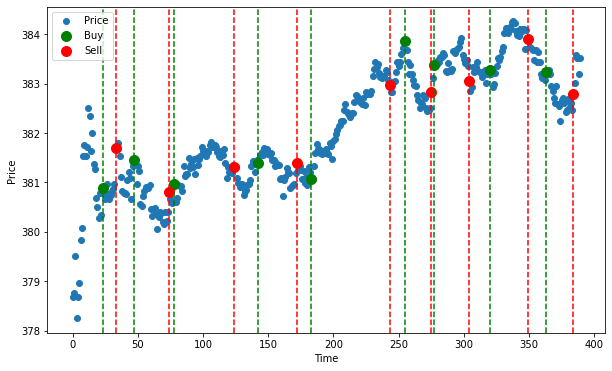

In [138]:
df = comp_days[400]
plt.figure(figsize=(10, 6))
plt.scatter(df.index, df["Close"], label="Price")

i = buy_list[0]
plt.axvline(x=i, linestyle="--", color="green")
plt.scatter(min(i, df.idxmax()[0]), df.iloc[min(i, df.idxmax()[0])]["Close"], color='green', s=100, label="Buy")

for i in buy_list[1:]:
    plt.axvline(x=i, linestyle="--", color="green")
    plt.scatter(min(i, df.idxmax()[0]), df.iloc[min(i, df.idxmax()[0])]["Close"], color='green', s=100)
    
i = sell_list[0] 
plt.axvline(x=i, linestyle="--", color="red")
plt.scatter(min(i, df.idxmax()[0]), df.iloc[min(i, df.idxmax()[0])]["Close"], color='red', s=100, label="Sell")

for i in sell_list[1:]:
    plt.axvline(x=i, linestyle="--", color="red")
    plt.scatter(min(i, df.idxmax()[0]), df.iloc[min(i, df.idxmax()[0])]["Close"], color='red', s=100)
    
# Add labels for price and time
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()